hi bye

In [44]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [45]:
import pandas as pd
import numpy as np
!pip install mne
import mne

In [46]:
#### Load data ####
raw_data = {"nabeha":[], "heidi":[], "avni":[]}

# Iterate thru all trials for each subject
for subj in raw_data.keys():
  for i in range(1,6):
    # Load data from CSV into an array
    trial_data = np.genfromtxt('/content/drive/Shareddrives/Neuromancers_Data/'+subj+'_data/OpenBCISession_'+subj+'_'+str(i)+'/BrainFlow-RAW_'+subj+'_'+str(i)+'_0.csv', delimiter='\t', dtype=str)
    trial_data = np.char.replace(trial_data, '\t', ' ')
    trial_data = trial_data.astype(float)

    # Declares channel names and types of each set of data
    ch_names = ['Channel {}'.format(i) for i in range(trial_data.shape[1])]
    ch_types = ['eeg' for i in range(trial_data.shape[1])]

    # Create info structures and RawArray objects for each set of data
    sfreq = 250  # sample rate in Hz
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw_array = mne.io.RawArray(trial_data.T, info)

    # Removing irrelevant channels
    ch_names = [raw_array.ch_names]
    ch_names_to_keep = [ch_names[0][0:10]]
    raw_array = raw_array.pick_channels(ch_names_to_keep[0])

    # Add RawArray
    raw_data[subj].append(raw_array)

Creating RawArray with float64 data, n_channels=24, n_times=42545
    Range : 0 ... 42544 =      0.000 ...   170.176 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=24, n_times=46730
    Range : 0 ... 46729 =      0.000 ...   186.916 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=24, n_times=45473
    Range : 0 ... 45472 =      0.000 ...   181.888 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=24, n_times=42796
    Range : 0 ... 42795 =      0.000 ...   171.180 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=24, n_times=40260
    Range : 0 ... 40259 =      0.000 ...   161.036 secs
Ready.
NOTE: pick_channels() is a legacy f

In [71]:
import pandas as pd
import mne  # Assuming MNE is being used for EEG data

# Load segmentation data
data_segments = pd.read_csv('/content/drive/Shareddrives/Neuromancers_Data/EEG_Data_Segmentation.csv')

filtered_data = {"nabeha": [], "heidi": [], "avni": []}

# Iterate through all trials for each subject
for subj in filtered_data.keys():
    for i in range(5):
        # Filter current trial data
        curr_trial = raw_data[subj][i]
        print(curr_trial)
        filtered_trial = curr_trial.copy().filter(
            l_freq=0.5, h_freq=45, picks=None, method='fir', fir_design='firwin',
            l_trans_bandwidth='auto', h_trans_bandwidth='auto',
            filter_length='auto', phase='zero'
        )

        # Removing Bad Channels
        bad_channels = ['Channel 0', 'Channel 9']  # List of channel names to mark as bad
        filtered_trial.info['bads'] = bad_channels
        filtered_trial.pick_types(eeg=True, exclude='bads')

        # Crop filtered_trial to within experiment duration
        curr_row = data_segments[data_segments["Participant"] == f"{subj}_{i+1}"].index
        start = data_segments.at[curr_row[0], "Experiment Start"]
        end = data_segments.at[curr_row[0], "Experiment End"]

        duration = filtered_trial.times[-1] - filtered_trial.times[0]  # Time in seconds
        if end > duration:
            end = duration -1

        print(f"{subj}_{i+1}: {start} {end}")
        filtered_trial = filtered_trial.crop(tmin=start, tmax=end)

        # Add annotations with color
        annotate_start = data_segments.at[curr_row[0], "Annotate1_Start"]
        annotate_end = data_segments.at[curr_row[0], "Annotate1_End"]
        filtered_trial.annotations.append(onset=annotate_start, duration=annotate_end-annotate_start, description="Annotation 1")

        # Add annotations with color
        annotate_start = data_segments.at[curr_row[0], "Annotate2_Start"]
        annotate_end = data_segments.at[curr_row[0], "Annotate2_End"]
        filtered_trial.annotations.append(onset=annotate_start, duration=annotate_end-annotate_start, description="Annotation 2")

        # Add filtered_trial to filtered_data dictionary
        filtered_data[subj].append(filtered_trial)

<RawArray | 10 x 42545 (170.2 s), ~3.3 MiB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
nabeha_1: 56.6031814 146.1235613
<RawArray | 10 x 46730 (186.9 s), ~3.6 MiB, data loaded>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

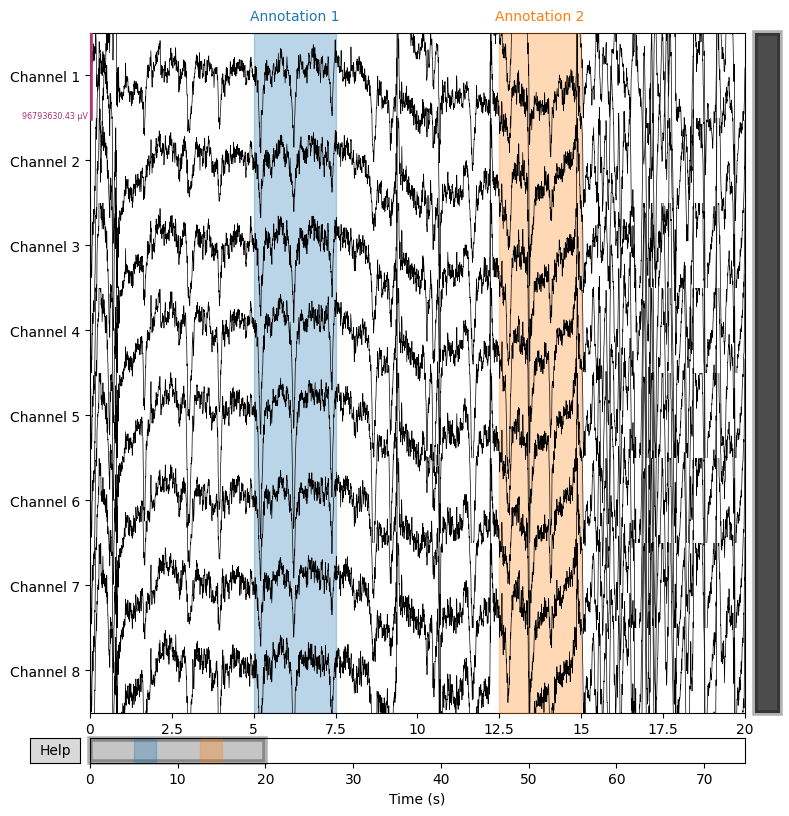

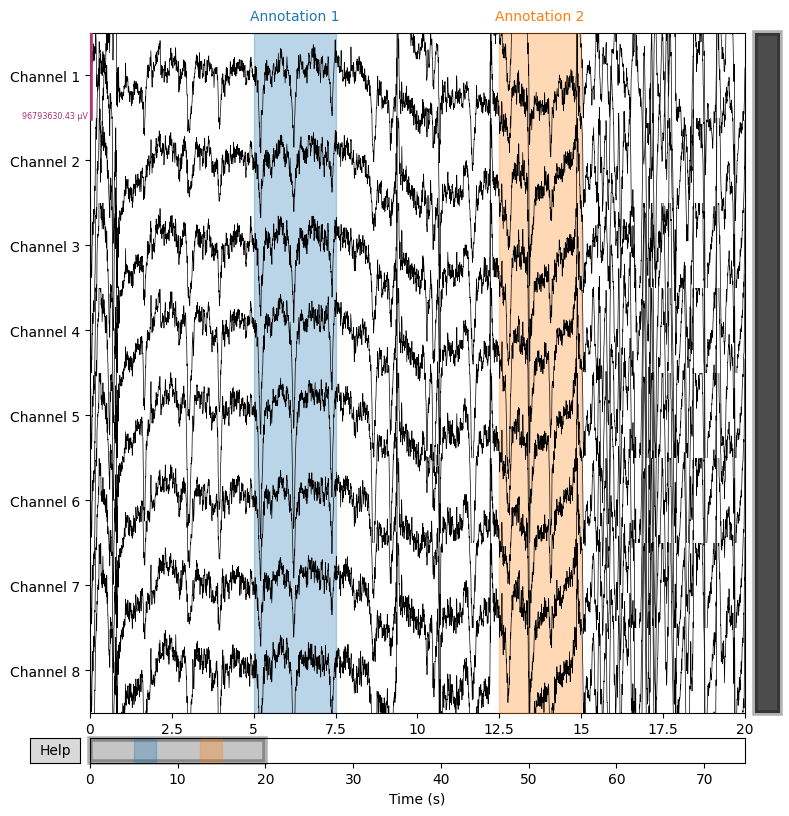

In [72]:
trial = filtered_data["avni"][4]
trial.plot(duration=20,scalings='auto')